## Importing the Libraries

In [1]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

Using TensorFlow backend.


## Loading the Data

Defining a function to load the data in sorted order

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
filelist_trainx = sorted(glob.glob('../input/*/trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('../input/*/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

Splitting the dataset into training set and test set to verify our model performance without any bias.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25)

Let's plot an image to see how the original images look.

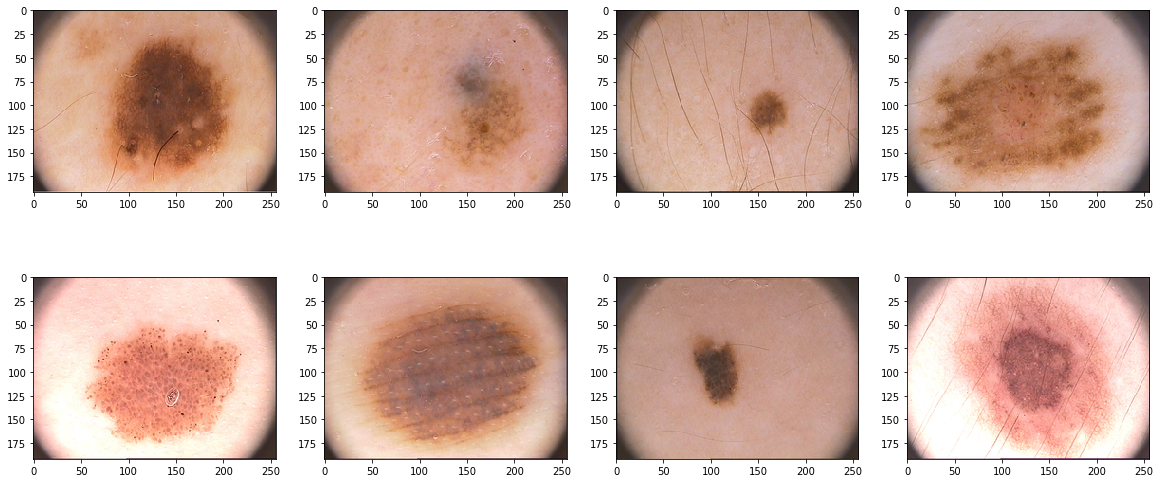

In [5]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()


Now let's see their corresponding masks.

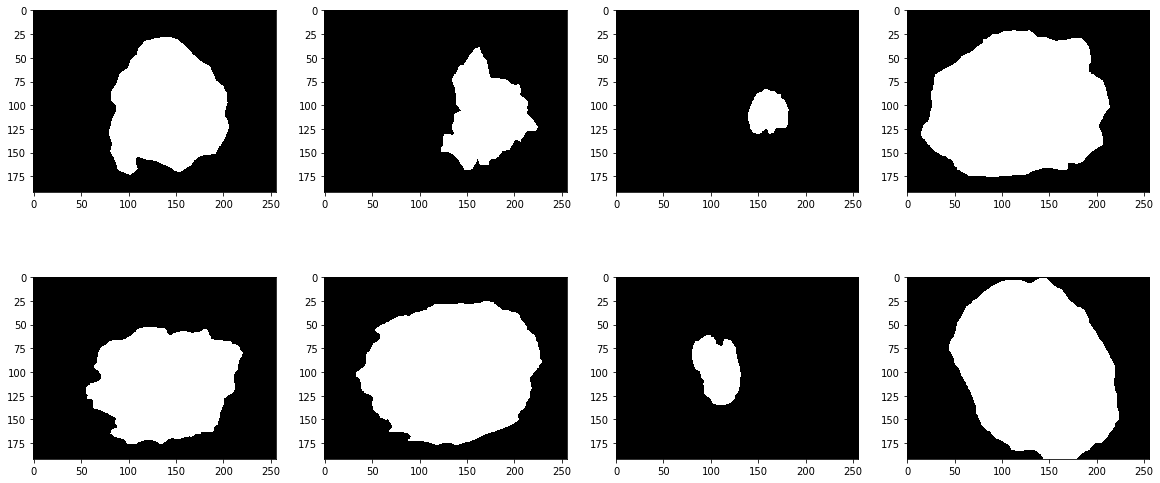

In [6]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

## Defining the Loss Function

#### Jaccard Distance  
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union:

![jd](https://www.geeksforgeeks.org/wp-content/ql-cache/quicklatex.com-44046533fcd54e98cb53619b3390e083_l3.svg)

In [7]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

## Defining Evaluation Metrics

#### Intersection over Union  
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![iou](https://www.d2l.ai/_images/iou.svg)

In [8]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### Dice coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![dc](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [9]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Precision    
Precision is a good measure to determine, when the costs of False Positive is high.

![precsion](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [10]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#### Recall  
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [11]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#### Accuracy

In [12]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Image Augmentation  
To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for **random rotation** and one for **horizontal flipping**

In [13]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [14]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [15]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

calling the functions for the training data.

In [16]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

Let us have a look at our transformations.

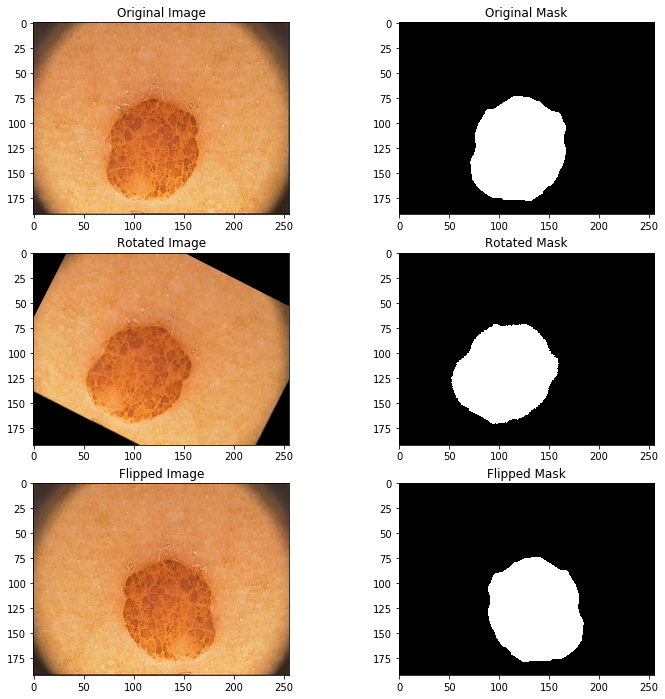

In [17]:
img_num = 114
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

Now we join all the augmentations image arrays to the original training arrays.

In [18]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

#### Making a Validation Set
We will split our full training set into train and validation set.  
Validation dataset is used to validate the performance after each epoch.

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [20]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


## The Model

Defining the model in a function which takes two arguments when called
* **epoch_num**: number of epochs to run  
* **savename**: the name of the model for saving after training

#### Optimizer and Learning Rate  
* We adopt adam optimization algorithm or adaptive moments, to adjust the learning rate.   
* It is well known that learning rate is one of the critical hyperparameters that have a signiﬁcant impact on classiﬁcation performance.     
* Advantages of Adam optimizer are:
    - Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum).
    - Usually works well even with a little tuning of hyperparameter
* Adam is fairly robust to the choice of hyperparameters, and set the learning rate **α** as 0.003 to speed up the training procedure in this study as advised in the paper [here](https://arxiv.org/pdf/1703.05165v2.pdf)

### Model Function

![arch](https://raw.githubusercontent.com/hashbanger/Skin_Lesion_Segmentation/master/graphics/fcn_arch.png)

In [21]:
def fcn_net(epochs_num,savename):

    # Convolution Layers (BatchNorm after non-linear activation)

    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Deconvolution Layers (BatchNorm after non-linear activation)

    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn9')(x)
    
    x = Dropout(0.5)(x)

    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])

    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)

    model.save(savename)
    return model,hist

<font color='red'>**Problems In Guided Dropout Implementation**     
            
- The entire network architecture is implemented using Keras.  
- Now to implement the Guided Dropout Layer using Keras we have to know the detailed backend of the Keras Library because:  
- We should know in what form the inputs will be coming to our layer so we could manipulate them.  
- We should also know in what form the output should be given to the next layer.  
- If we implement Guided Dropout from scratch then we will have to implement entire architecture from scratch which will be neither efficient nor easily feasible.</font>

**After 1 epoch**

In [22]:
model, hist = fcn_net(epochs_num= 1, savename= 'fcn_1_epochs.h5')

Train on 360 samples, validate on 90 samples
Epoch 1/1
360/360 [==============================] - 13s 37ms/step - loss: 0.2718 - iou: 0.7282 - dice_coef: 0.4778 - precision: 0.6617 - recall: 0.3432 - accuracy: 0.7258 - val_loss: 0.4832 - val_iou: 0.5168 - val_dice_coef: 0.4818 - val_precision: 0.3144 - val_recall: 1.0000 - val_accuracy: 0.3163


## Loading the Model

Here we can load a pretrained model

In [23]:
img_input = Input(shape= (192, 256, 3))
x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dropout(0.5)(x)

x = Conv2D(512, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)

# Deconvolution Layers (BatchNorm after non-linear activation)

x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn9')(x)

x = Dropout(0.5)(x)

x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)


In [24]:
model_0 = Model(inputs=img_input, outputs=pred)
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou, dice_coef, precision, recall, accuracy])

In [25]:
model_0.load_weights('fcn_1_epochs.h5')

In [26]:
print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

360/360 [==============================] - 3s 8ms/step
________________________
IOU:       |   52.40  |
Dice Coef: |   49.07  |
Precision: |   32.42  |
Recall:    |   99.99  |
Accuracy:  |   32.65  |
Loss:      |   47.60  |
________________________

-------------On Test  Set--------------------------

50/50 [==============================] - 1s 14ms/step
________________________
IOU:       |   51.68  |
Dice Coef: |   48.17  |
Precision: |   31.48  |
Recall:    |   100.00  |
Accuracy:  |   31.71  |
Loss:      |   48.32  |
________________________

-------------On validation Set---------------------

90/90 [==============================] - 1s 7ms/step
________________________
IOU:       |   51.68  |
Dice Coef: |   48.18  |
Precision: |   31.44  |
Recall:    |   100.00  |
Accuracy:  |   31.63  |
Loss:      |   48.32  |
________________________


#### After 100 epochs

In [27]:
model, hist = fcn_net(epochs_num= 100, savename= 'fcn_100_epoch.h5')

Train on 360 samples, validate on 90 samples
Epoch 1/100
360/360 [==============================] - 10s 28ms/step - loss: 0.2636 - iou: 0.7364 - dice_coef: 0.4977 - precision: 0.6938 - recall: 0.3960 - accuracy: 0.7309 - val_loss: 0.2151 - val_iou: 0.7849 - val_dice_coef: 0.6587 - val_precision: 0.5638 - val_recall: 0.8635 - val_accuracy: 0.7481
Epoch 2/100
360/360 [==============================] - 7s 19ms/step - loss: 0.2334 - iou: 0.7666 - dice_coef: 0.5346 - precision: 0.8340 - recall: 0.4132 - accuracy: 0.7822 - val_loss: 0.1665 - val_iou: 0.8335 - val_dice_coef: 0.5610 - val_precision: 0.9683 - val_recall: 0.4554 - val_accuracy: 0.8260
Epoch 3/100
360/360 [==============================] - 7s 19ms/step - loss: 0.2311 - iou: 0.7689 - dice_coef: 0.5362 - precision: 0.8527 - recall: 0.4027 - accuracy: 0.7837 - val_loss: 0.2756 - val_iou: 0.7244 - val_dice_coef: 0.5747 - val_precision: 0.4690 - val_recall: 0.9394 - val_accuracy: 0.6506
Epoch 4/100
360/360 [===========================

In [28]:
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou, dice_coef, precision, recall, accuracy])

In [29]:
model_1.load_weights('fcn_100_epoch.h5')

Testing the statistics after 100 epochs

In [30]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

360/360 [==============================] - 3s 8ms/step
________________________
IOU:       |   90.90  |
Dice Coef: |   70.84  |
Precision: |   95.65  |
Recall:    |   79.60  |
Accuracy:  |   92.30  |
Loss:      |   9.10  |
________________________

-------------On Test  Set--------------------------

50/50 [==============================] - 0s 7ms/step
________________________
IOU:       |   91.19  |
Dice Coef: |   71.34  |
Precision: |   95.77  |
Recall:    |   81.18  |
Accuracy:  |   93.10  |
Loss:      |   8.81  |
________________________

-------------On validation Set---------------------

90/90 [==============================] - 1s 7ms/step
________________________
IOU:       |   90.53  |
Dice Coef: |   70.85  |
Precision: |   94.28  |
Recall:    |   80.31  |
Accuracy:  |   92.08  |
Loss:      |   9.47  |
________________________


### Plotting Training Statistics

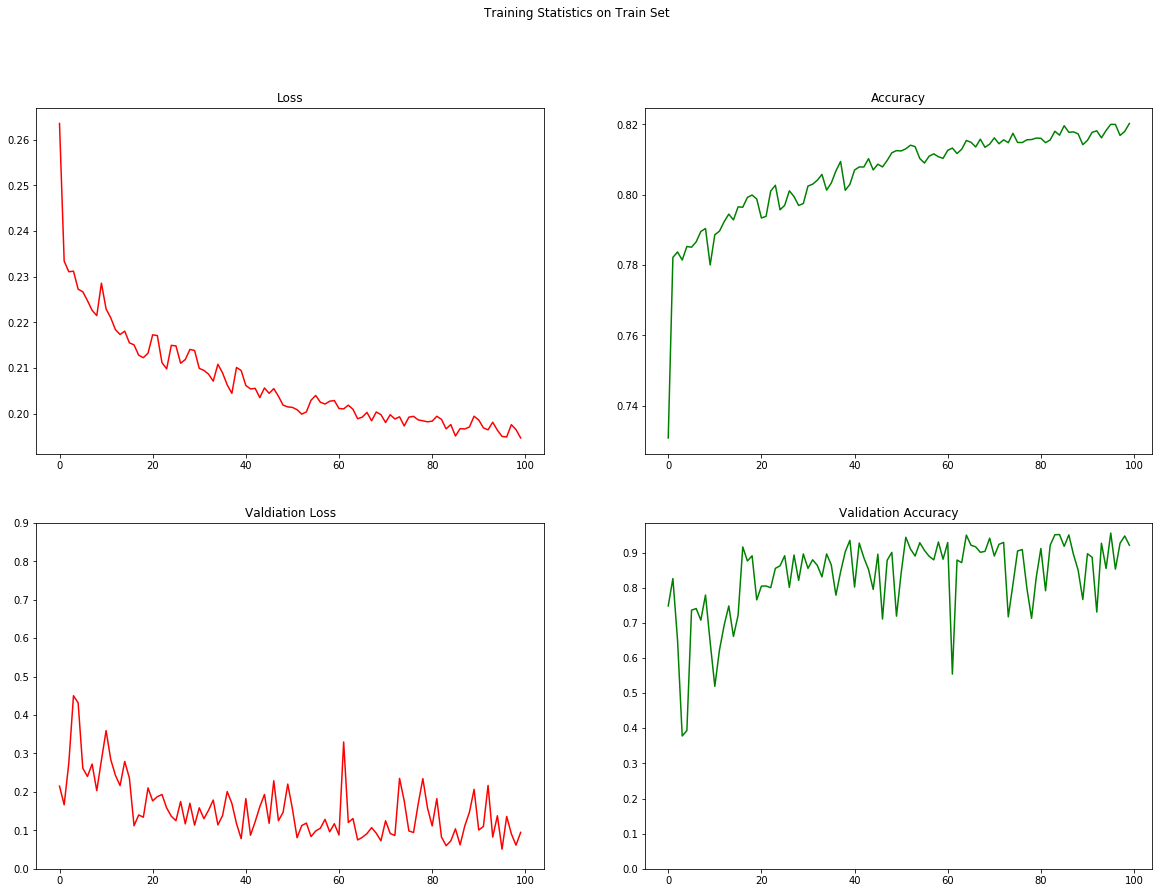

In [31]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()


From the above plot we can see that for the training set the the loss and the accuracy has gradually decreased and increased respetively.  
Although for the validation set the loss and the accuracy fluctuates but the loss and the accuracy are relatively low and high respectively throughout the training.  
Also the fluctuations relatively lowers towards the end of the training.

## Visualising Predicted Lesions

We have trained the model on the **training set**.  
We will make predictions on the unseen **test set**

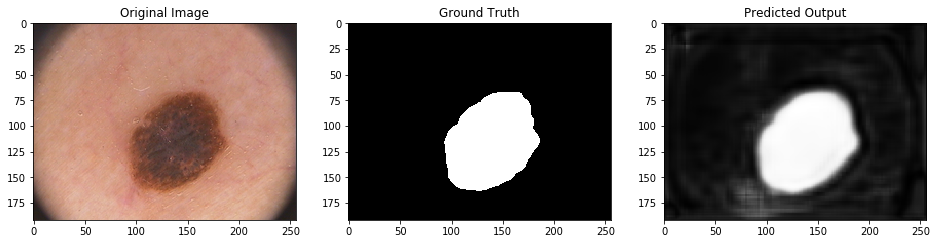

In [32]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

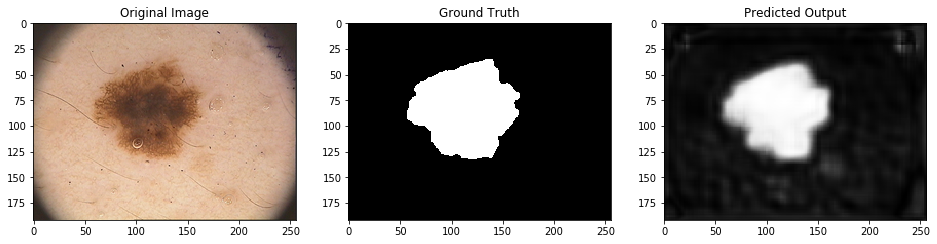

In [33]:
img_num = 10
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

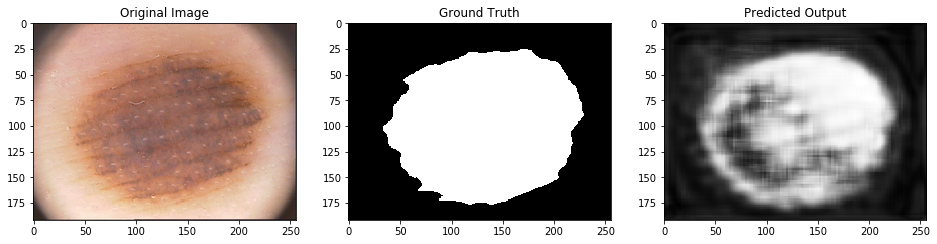

In [34]:
img_num = 36
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

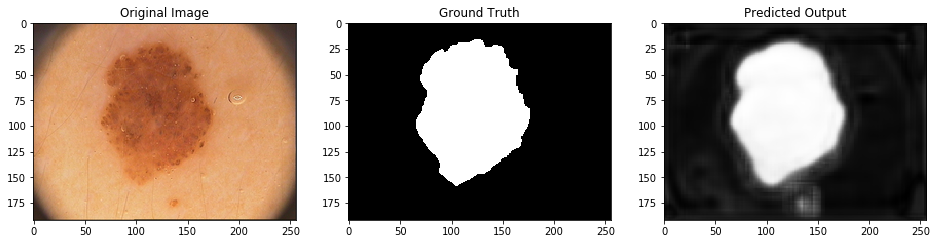

In [35]:
img_num = 32
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

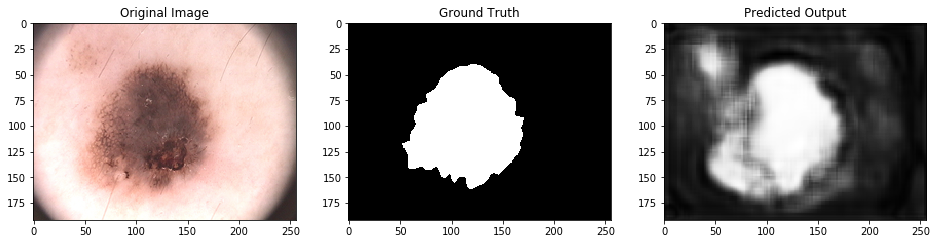

In [36]:
img_num = 29
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

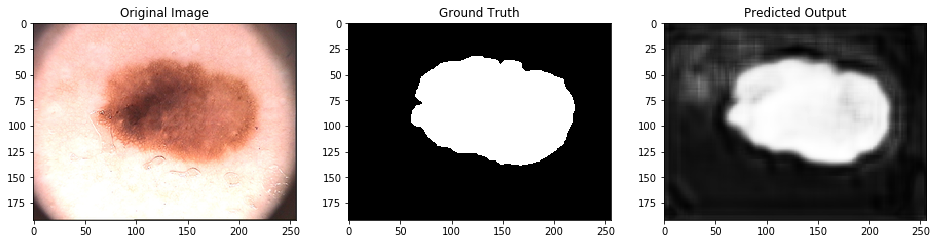

In [37]:
img_num = 21
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

## Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.  
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.5  .
* While rounding down the pixel values to 0 which are < 0.5.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values.

In [38]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



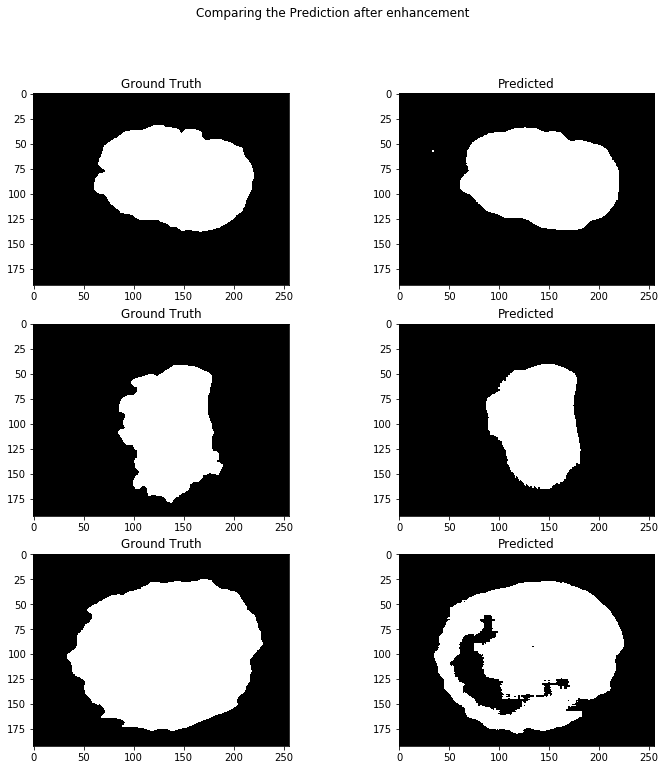

In [39]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

* So we can observe that our results are very good on the Test dataset which suggests that the model is quite robust and well performing too.

### **de nada!**